Global Temperature Analysis GUI front-end including regression model, prophet and EDA step

Data upload

In [57]:
import pandas as pd

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [58]:
df_clean = pd.read_csv(r"/content/drive/MyDrive/Data/GlobalTemp_Cleaned_CountryContinent.csv")
df_post1850 = pd.read_csv(r"/content/drive/MyDrive/Data/GlobalTemp_Post1850.csv")
df_annual_anomalies = pd.read_csv(r"/content/drive/MyDrive/Data/Annual_Anomalies.csv")

###Basic Regression Model setup

In [59]:
import statsmodels.formula.api as smf

# Recreate regression dataset (post-1900 anomalies by continent)
df_reg = df_annual_anomalies[df_annual_anomalies["Year"] >= 1900].copy()

# Add centered year
df_reg["YearCentered"] = df_reg["Year"] - 1900

# Run regression
model_centered = smf.ols("Anomaly ~ YearCentered + C(Continent)", data=df_reg).fit()
print(model_centered.summary())

                            OLS Regression Results                            
Dep. Variable:                Anomaly   R-squared:                       0.595
Model:                            OLS   Adj. R-squared:                  0.591
Method:                 Least Squares   F-statistic:                     165.7
Date:                Thu, 02 Oct 2025   Prob (F-statistic):          2.52e-150
Time:                        22:46:19   Log-Likelihood:                -202.28
No. Observations:                 798   AIC:                             420.6
Df Residuals:                     790   BIC:                             458.0
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept     

###Visualization of temperature variation by continet and season

Technically part of the EDA, but was not needed until now.

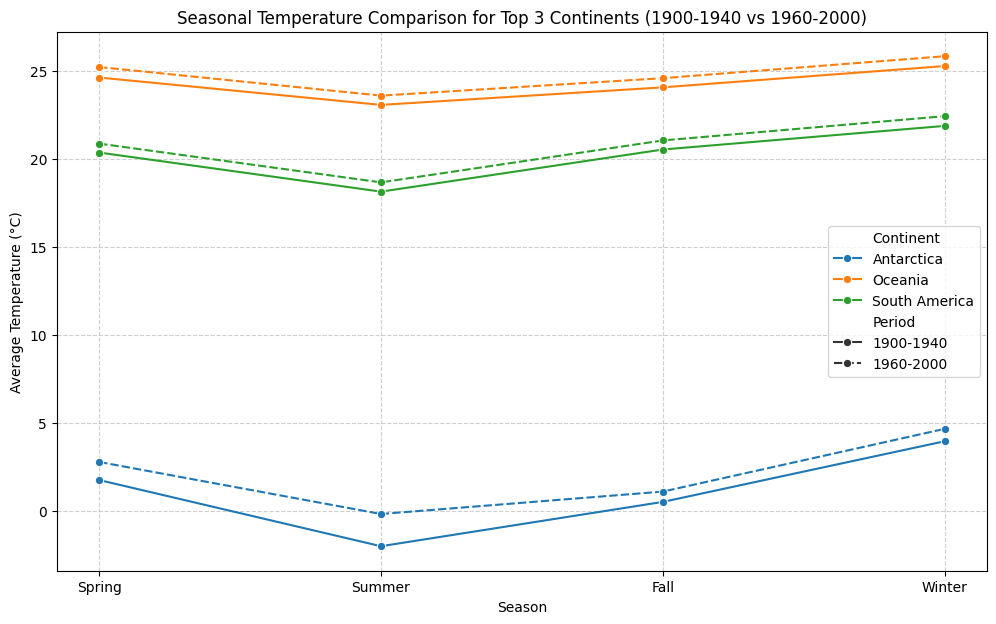

In [60]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Ensure 'dt' column is datetime type
df_clean['dt'] = pd.to_datetime(df_clean['dt'])

# Filter data for the two periods
df_1900_1940 = df_clean[(df_clean['Year'] >= 1900) & (df_clean['Year'] <= 1940)].copy()
df_1960_2000 = df_clean[(df_clean['Year'] >= 1960) & (df_clean['Year'] <= 2000)].copy()

# Calculate seasonal means for each period
seasonal_means_1900_1940 = df_1900_1940.groupby(['Continent', 'Season'])['AverageTemperature'].mean().reset_index()
seasonal_means_1960_2000 = df_1960_2000.groupby(['Continent', 'Season'])['AverageTemperature'].mean().reset_index()

# Define the correct season order
season_order = ["Spring", "Summer", "Fall", "Winter"]
seasonal_means_1900_1940["Season"] = pd.Categorical(seasonal_means_1900_1940["Season"], categories=season_order, ordered=True)
seasonal_means_1960_2000["Season"] = pd.Categorical(seasonal_means_1960_2000["Season"], categories=season_order, ordered=True)

# Sort by continent and season
seasonal_means_1900_1940 = seasonal_means_1900_1940.sort_values(['Continent', 'Season'])
seasonal_means_1960_2000 = seasonal_means_1960_2000.sort_values(['Continent', 'Season'])

# Merge the two dataframes for easy comparison
seasonal_compare = pd.merge(seasonal_means_1900_1940, seasonal_means_1960_2000, on=['Continent', 'Season'], suffixes=('_1900_1940', '_1960_2000'))

# Calculate the difference and its absolute value to find largest differences
seasonal_compare['Temperature_Difference'] = seasonal_compare['AverageTemperature_1960_2000'] - seasonal_compare['AverageTemperature_1900_1940']
seasonal_compare['Abs_Temperature_Difference'] = abs(seasonal_compare['Temperature_Difference'])

# Find the continents with the top 3 largest average absolute differences
top_continents = seasonal_compare.groupby('Continent')['Abs_Temperature_Difference'].mean().nlargest(3).index.tolist()

# Filter the comparison dataframe for the top continents
seasonal_compare_top = seasonal_compare[seasonal_compare['Continent'].isin(top_continents)].copy()

# Reshape data for easier plotting with seaborn
seasonal_compare_top_melted = seasonal_compare_top.melt(id_vars=['Continent', 'Season'],
                                                        value_vars=['AverageTemperature_1900_1940', 'AverageTemperature_1960_2000'],
                                                        var_name='Period', value_name='AverageTemperature')

# Clean up Period names
seasonal_compare_top_melted['Period'] = seasonal_compare_top_melted['Period'].str.replace('AverageTemperature_', '').str.replace('_', '-')


# Plotting the top continents in a single graph
plt.figure(figsize=(12, 7))
sns.lineplot(data=seasonal_compare_top_melted, x='Season', y='AverageTemperature', hue='Continent', style='Period', marker='o')

plt.title('Seasonal Temperature Comparison for Top 3 Continents (1900-1940 vs 1960-2000)')
plt.xlabel('Season')
plt.ylabel('Average Temperature (°C)')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

###Visualization of the models success

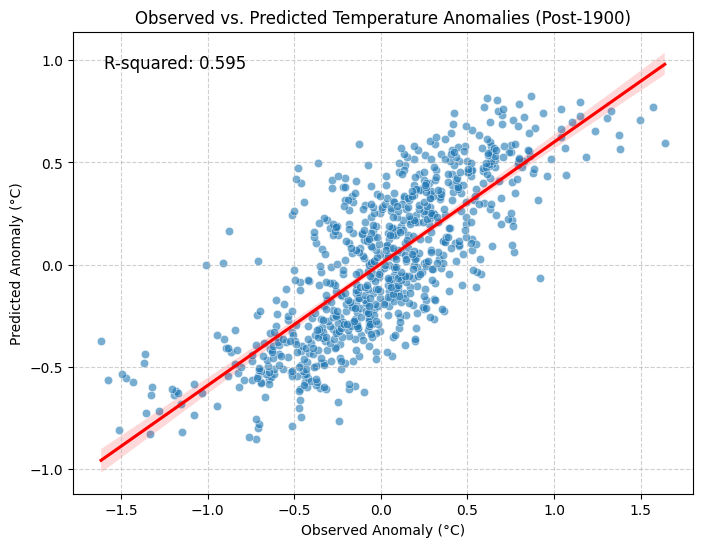

In [61]:
import matplotlib.pyplot as plt
import seaborn as sns

# Add predictions and residuals to the regression dataframe
df_reg["Predicted"] = model_centered.predict(df_reg)
df_reg["Residuals"] = model_centered.resid

# Scatter plot of Observed vs. Predicted values with regression line
plt.figure(figsize=(8, 6))
sns.scatterplot(x="Anomaly", y="Predicted", data=df_reg, alpha=0.6)
sns.regplot(x="Anomaly", y="Predicted", data=df_reg, scatter=False, color='red', ci=95) # Add regression line with CI

# Adding R-squared to the plot
r_squared = model_centered.rsquared
plt.text(0.05, 0.95, f'R-squared: {r_squared:.3f}', transform=plt.gca().transAxes, fontsize=12, verticalalignment='top')

plt.title("Observed vs. Predicted Temperature Anomalies (Post-1900)")
plt.xlabel("Observed Anomaly (°C)")
plt.ylabel("Predicted Anomaly (°C)")
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

This scatter plot displays the relationship between observed and predicted temperature anomalies recorded since 1900. The data shows a positive correlation between the two variables, with an R-squared value of 0.595, indicating that approximately 59.5% of the variation in predicted temperature anomalies can be explained by observed measurements.

The plot reveals temperature anomalies ranging from approximately -1.5°C to 1.5°C for observed values and -1.0°C to 1.0°C for predicted values. While there is some scatter around the trend line (shown in red), the strong positive correlation suggests that climate models have moderate predictive power in capturing actual temperature changes over this period. This visualization is likely part of climate science research evaluating the accuracy of temperature prediction models against historical records.

##Prophet being set with higher tcurrent year for future prediction capacity.

In [62]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from prophet import Prophet
from sklearn.metrics import mean_squared_error

# --- Prepare Europe anomalies for Prophet ---
df_europe = (df_annual_anomalies
             .query("Continent == 'Europe' and Year >= 1900")
             .sort_values("Year"))

# Prophet requires 'ds' (date) and 'y' (value)
df_prophet = df_europe.rename(columns={"Year": "ds", "Anomaly": "y"})
df_prophet["ds"] = pd.to_datetime(df_prophet["ds"], format="%Y")

# --- Train/test split ---
train = df_prophet[df_prophet["ds"].dt.year <= 1980].copy()
test  = df_prophet[df_prophet["ds"].dt.year > 1980].copy()

# --- Fit Prophet model ---
model = Prophet(yearly_seasonality=False, weekly_seasonality=False, daily_seasonality=False)
model.fit(train)

# --- Build future frame far enough out (e.g., 2013) ---
last_year = test["ds"].dt.year.max()   # should be 2013
n_periods = last_year - train["ds"].dt.year.max()
future = model.make_future_dataframe(periods=n_periods, freq="Y")
forecast = model.predict(future)

# --- Evaluate by matching on Year, not exact datetime ---
forecast["Year"] = forecast["ds"].dt.year
test["Year"] = test["ds"].dt.year

merged = pd.merge(test[["Year","y"]],
                  forecast[["Year","yhat"]],
                  on="Year",
                  how="inner")

rmse = np.sqrt(mean_squared_error(merged["y"], merged["yhat"]))
print(f"Europe Prophet RMSE (1981–2013): {rmse:.3f} °C")

merged = pd.merge(test[["Year","y"]],
                  forecast[["Year","yhat"]],
                  on="Year",
                  how="inner")

rmse = np.sqrt(mean_squared_error(merged["y"], merged["yhat"]))
print(f"Europe Prophet RMSE (1981–2013): {rmse:.3f} °C")


DEBUG:cmdstanpy:input tempfile: /tmp/tmpobc_4ur8/r_ftvxus.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpobc_4ur8/dck3oq1m.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=46578', 'data', 'file=/tmp/tmpobc_4ur8/r_ftvxus.json', 'init=/tmp/tmpobc_4ur8/dck3oq1m.json', 'output', 'file=/tmp/tmpobc_4ur8/prophet_modelmcvhf3ia/prophet_model-20251002224620.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
22:46:20 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:46:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Europe Prophet RMSE (1981–2013): 0.682 °C
Europe Prophet RMSE (1981–2013): 0.682 °C


In [63]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from prophet import Prophet
from sklearn.metrics import mean_squared_error
from pathlib import Path

# --- Config ---
train_end, test_end = 1980, 2013
outdir = Path("forecast_prophet_continents")
outdir.mkdir(parents=True, exist_ok=True)

# --- Prep dataframe ---
dfc = (df_annual_anomalies[["Year","Continent","Anomaly"]]
       .dropna()
       .query("Year >= 1900")
       .sort_values(["Continent","Year"]))

continents = dfc["Continent"].unique()

scores = []

for cont in continents:
    df_cont = dfc[dfc["Continent"] == cont].copy()

    # Prophet format
    df_prophet = df_cont.rename(columns={"Year":"ds","Anomaly":"y"})
    df_prophet["ds"] = pd.to_datetime(df_prophet["ds"], format="%Y")

    # Train/test split
    train = df_prophet[df_prophet["ds"].dt.year <= train_end].copy()
    test  = df_prophet[df_prophet["ds"].dt.year > train_end].copy()

    if len(test) == 0 or len(train) < 30:
        continue  # skip if too little data

    # Fit Prophet
    model = Prophet(yearly_seasonality=False,
                    weekly_seasonality=False,
                    daily_seasonality=False)
    model.fit(train)

    # Extend future to cover test years
    horizon = test["ds"].dt.year.max() - train["ds"].dt.year.max()
    future = model.make_future_dataframe(periods=horizon, freq="Y")
    forecast = model.predict(future)

    # Align forecast with test years
    forecast["Year"] = forecast["ds"].dt.year
    test["Year"] = test["ds"].dt.year
    merged = pd.merge(test[["Year","y"]],
                      forecast[["Year","yhat"]],
                      on="Year",
                      how="inner")

    if merged.empty:
        continue

    rmse = np.sqrt(mean_squared_error(merged["y"], merged["yhat"]))
    scores.append({"Continent": cont, "Prophet_RMSE": rmse})

# --- RMSE results ---
rmse_table_prophet = pd.DataFrame(scores).sort_values("Prophet_RMSE")
rmse_table_prophet

DEBUG:cmdstanpy:input tempfile: /tmp/tmpobc_4ur8/3ss_e8kd.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpobc_4ur8/0jrhk9wo.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=50990', 'data', 'file=/tmp/tmpobc_4ur8/3ss_e8kd.json', 'init=/tmp/tmpobc_4ur8/0jrhk9wo.json', 'output', 'file=/tmp/tmpobc_4ur8/prophet_model09kxn0zq/prophet_model-20251002224620.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
22:46:20 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:46:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpobc_4ur8/trvaf1y0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpobc_4ur8/hytsso_d.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local

,Continent,Prophet_RMSE
5,Oceania,0.140005
1,Antarctica,0.208548
6,South America,0.224092
4,North America,0.278467
2,Asia,0.393128
0,Africa,0.500454
3,Europe,0.681902


this warning was showing with the output for the widget, so I silenced it

In [64]:
import warnings

# Filter out the specific FutureWarning from Prophet related to date_range frequency
warnings.filterwarnings("ignore", category=FutureWarning, module="prophet")

In [65]:
#  Build Interactive Interface and Display Output

import ipywidgets as widgets
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns

# Get unique continents, years, and seasons from the data
available_continents = sorted(dfc_prophet["Continent"].unique().tolist())
available_years = sorted(dfc_prophet["ds"].dt.year.unique().tolist())
available_seasons = ["Spring", "Summer", "Fall", "Winter"] # Assuming these are the standard seasons

# Create interactive widgets
continent_dropdown = widgets.Dropdown(
    options=available_continents,
    description='Continent:',
    disabled=False,
    style={'description_width': 'initial'}
)

year_slider = widgets.IntSlider(
    value=available_years[-1], # Start at the latest year
    min=available_years[0],
    max=available_years[-1] + 10, # Extend a few years beyond the data for forecasting
    step=1,
    description='Year:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d',
    style={'description_width': 'initial'}
)

season_dropdown = widgets.Dropdown(
    options=available_seasons,
    description='Season:',
    disabled=False,
    style={'description_width': 'initial'}
)

unit_radiobuttons = widgets.RadioButtons(
    options=['Celsius', 'Fahrenheit'],
    description='Unit:',
    disabled=False,
    style={'description_width': 'initial'}
)


output_widget = widgets.Output(layout={'border': '1px solid black', 'padding': '10px'}) # Add border and padding

# Function to convert Celsius to Fahrenheit
def c_to_f(celsius):
    return (celsius * 9/5) + 32

# Function to update output based on widget changes
def on_widget_change(change):
    with output_widget:
        output_widget.clear_output()
        continent = continent_dropdown.value
        year = year_slider.value
        season = season_dropdown.value
        unit = unit_radiobuttons.value

        prediction_celsius = predict_temperature(continent, year, season)

        if "Predicted Average Temperature Anomaly for" in prediction_celsius:
            # Extract the numerical value from the prediction string
            anomaly_celsius_str = prediction_celsius.split(': ')[1].split(' ')[0]
            try:
                anomaly_celsius = float(anomaly_celsius_str)
                if unit == 'Fahrenheit':
                    anomaly_fahrenheit = c_to_f(anomaly_celsius)
                    print(f"Predicted Average Temperature Anomaly for {continent} in {season} {year}: {anomaly_fahrenheit:.3f} °F")
                else:
                    print(f"Predicted Average Temperature Anomaly for {continent} in {season} {year}: {anomaly_celsius:.3f} °C")
            except ValueError:
                print(prediction_celsius) # Print the original message if parsing fails
        else:
            print(prediction_celsius) # Print error messages directly


# Link widgets to the update function
continent_dropdown.observe(on_widget_change, names='value')
year_slider.observe(on_widget_change, names='value')
season_dropdown.observe(on_widget_change, names='value')
unit_radiobuttons.observe(on_widget_change, names='value')


# Display the widgets and initial output
display(widgets.VBox([widgets.HBox([continent_dropdown, year_slider]),
                      widgets.HBox([season_dropdown, unit_radiobuttons]),
                      output_widget # Include the output widget in the main layout
                     ]))


# Trigger initial output
on_widget_change(None)

## Interactive Temperature Anomaly Forecaster

Use the widgets above to select a continent, year, and season to get a predicted average temperature anomaly using the trained Prophet model.

**Note:** This is a simplified forecast based on annual Prophet predictions combined with historical seasonal averages. For more accurate seasonal forecasting, a different modeling approach would be required.